<h1>laser_cutting_model<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Подготовка-к-эксперименту" data-toc-modified-id="Подготовка-к-эксперименту-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка к эксперименту</a></span><ul class="toc-item"><li><span><a href="#План-предобработки" data-toc-modified-id="План-предобработки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>План предобработки</a></span></li><li><span><a href="#Эксперимент" data-toc-modified-id="Эксперимент-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Эксперимент</a></span></li><li><span><a href="#&quot;Pipeline&quot;" data-toc-modified-id="&quot;Pipeline&quot;-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>"Pipeline"</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Разделим-на-выборки" data-toc-modified-id="Разделим-на-выборки-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Разделим на выборки</a></span></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#Стандартная-линейная-регрессия" data-toc-modified-id="Стандартная-линейная-регрессия-2.4.3"><span class="toc-item-num">2.4.3&nbsp;&nbsp;</span>Стандартная линейная регрессия</a></span></li></ul></li><li><span><a href="#Сравнение-baseline-и-regression" data-toc-modified-id="Сравнение-baseline-и-regression-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Сравнение baseline и regression</a></span></li><li><span><a href="#Улучшение-модели-(регуляризация)" data-toc-modified-id="Улучшение-модели-(регуляризация)-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Улучшение модели (регуляризация)</a></span><ul class="toc-item"><li><span><a href="#lasso" data-toc-modified-id="lasso-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>lasso</a></span></li><li><span><a href="#ridge" data-toc-modified-id="ridge-2.6.2"><span class="toc-item-num">2.6.2&nbsp;&nbsp;</span>ridge</a></span></li><li><span><a href="#ElasticNet" data-toc-modified-id="ElasticNet-2.6.3"><span class="toc-item-num">2.6.3&nbsp;&nbsp;</span>ElasticNet</a></span></li></ul></li><li><span><a href="#Сравнение-результатов" data-toc-modified-id="Сравнение-результатов-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Сравнение результатов</a></span></li><li><span><a href="#Улучшение-модели-(полином)" data-toc-modified-id="Улучшение-модели-(полином)-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Улучшение модели (полином)</a></span></li></ul></li><li><span><a href="#Визуализация-результатов" data-toc-modified-id="Визуализация-результатов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Визуализация результатов</a></span></li><li><span><a href="#Итог" data-toc-modified-id="Итог-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Итог</a></span></li></ul></div>

# Импорт библиотек

Импорты и функции вынесены в отдельный файл

In [1]:
import sys
sys.path.append('../')

In [2]:
from src.utils import *
from preprocessing import get_preprocessed_data

In [3]:
data = get_preprocessed_data()

/home/mikhail/projects/laser_cutting/notebooks/preprocessing.py:73: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['operation_num'] = data['Operation'].replace(mapping)


## Обучение моделей

Устанавливаем параметры локального сервера MLflow

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

# Установите путь к директории артефактов
mlflow.set_tracking_uri(os.getenv('MLFLOW_TRACKING_URI'))
mlflow.set_experiment("Laser_cutting")

<Experiment: artifact_location='file:///home/mikhail/projects/laser_cutting/artifacts/mlruns/674144911510648994', creation_time=1726078890412, experiment_id='674144911510648994', last_update_time=1726078890412, lifecycle_stage='active', name='Laser_cutting', tags={}>

Посмотрим на корреляционную матрицу, чтобы выбрать признаки для обучения

Сначала убираем нечисловые признаки

In [5]:
to_drop=['Part_name', 'Material', 'Operation', 'hash', 'keywords','Material_mark']
data.drop(to_drop, inplace=True, axis=1)

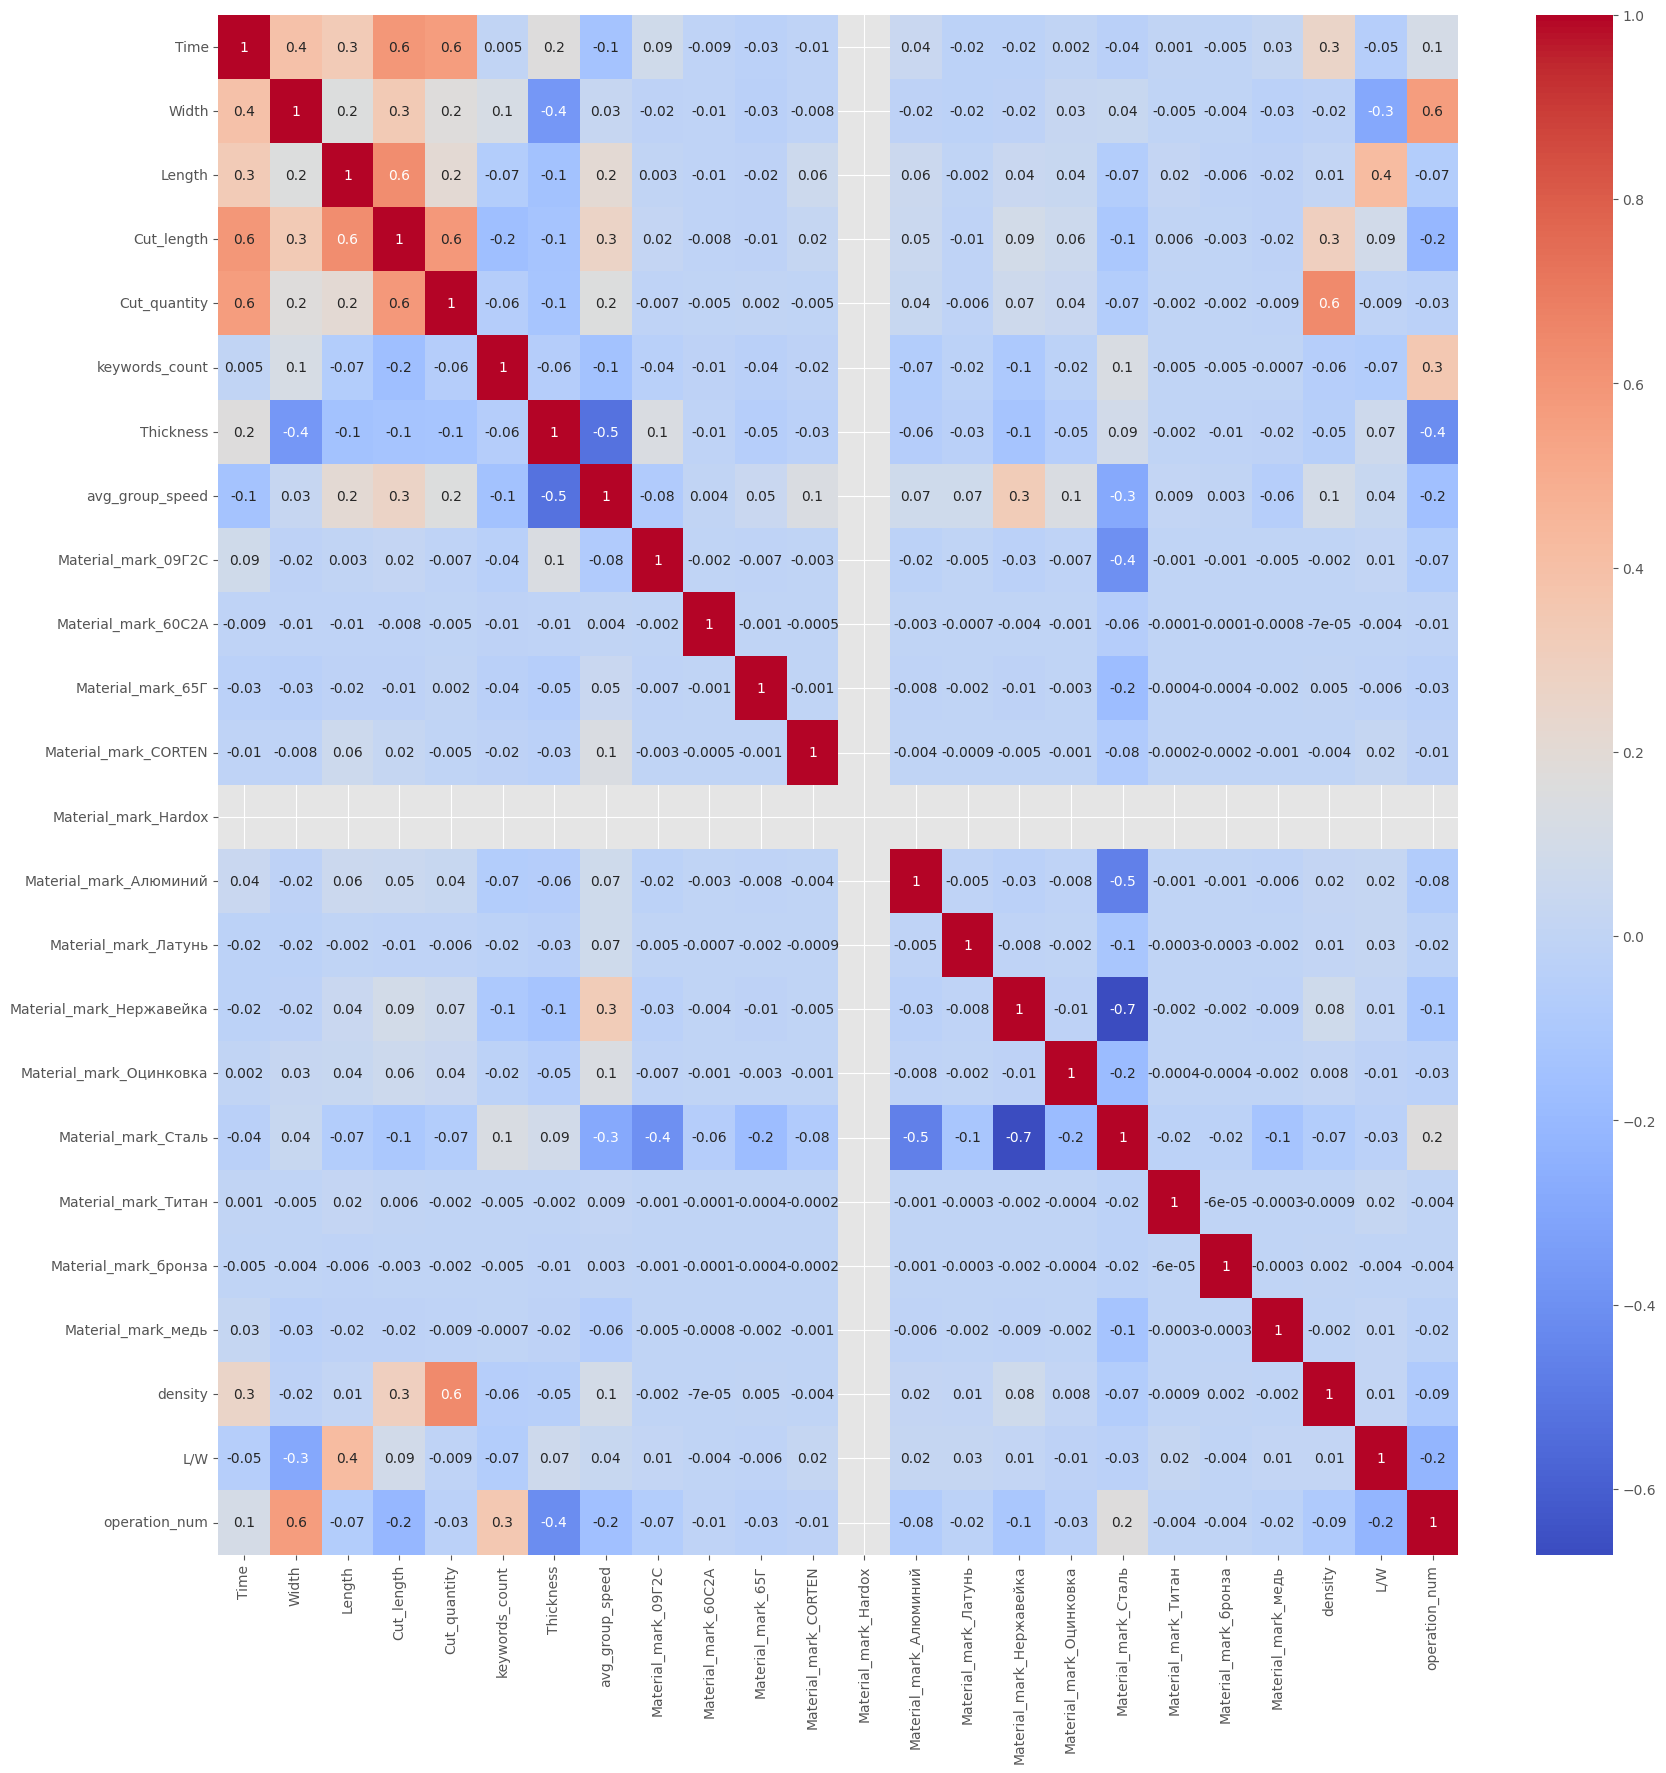

In [6]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data.corr(), annot = True, ax=ax, fmt='.1g', cmap= 'coolwarm');

Для модели возьмем признаки, с корреляцией более 0.2

### Разделим на выборки

In [7]:
X = data.drop('Time', axis=1)
y = data['Time']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

Создадим датасет для сравнения, добавим baseline

### Baseline

Для baseline просто считаем по формуле

In [8]:
with mlflow.start_run(run_name="Baseline"):
    # Логируем параметры модели
    mlflow.log_param("model_type", "Baseline")
    
    start_time = datetime.now()
    compare = X_test.copy()
    compare['base_y_pred'] = compare['Cut_length'] / compare['avg_group_speed']
    compare = compare.join(y_test)
    end_time = datetime.now()
    
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
       
    # Вычисляем метрики  
    actual_values = compare['Time']
    predicted_values = compare['base_y_pred']
    base_metrics=get_and_print_metrics(predicted_values, actual_values)
    
    
#     # Логируем метрики
    for key, value in base_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.log_param("baselie", "base_y_pred = Cut_length / avg_group_speed")

RMSE: 35.3924914358448
MAPE: 48.04%
SMAPE: 39.18%
R2: 0.31
Процент значений с ошибкой не более 20%: 43.13%
WAPE: 41.87%


In [9]:
compare[['base_y_pred', 'Time']].head(3)

,base_y_pred,Time
405302,68.148,70.000
250899,32.508,40.000
398875,21.668,19.000


На глаз, для первых 3 значений, предсказаниче получилось достаточно точным

### Стандартная линейная регрессия

Обучаем линейную регрессию. Сначала стандартизируем данные

In [10]:
scaler = StandardScaler()
#scaler = QuantileTransformer(random_state=0)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),
                                   columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val),
                                   columns=X_val.columns, index=X_val.index)

In [11]:
cols=['Cut_length', 'Material_mark_09Г2С', 'Material_mark_60С2А',
                 'Material_mark_65Г', 'Material_mark_CORTEN', 'Material_mark_Hardox',
                 'Material_mark_Алюминий', 'Material_mark_Латунь', 'Material_mark_Нержавейка',
                 'Material_mark_Оцинковка', 'Material_mark_Сталь', 'Material_mark_Титан',
                 'Material_mark_бронза', 'Cut_quantity', 'Thickness',
      'density', 'operation_num']
X = X_train[cols]
y = y_train


with mlflow.start_run(run_name="Linear"):
    mlflow.log_param("model_type", "Linear")
        
    start_time = datetime.now()
    reg = LinearRegression()
    reg.fit(X, y)
    y_linear_predict = reg.predict(X_test[cols])
    compare['y_linear_predict'] = y_linear_predict
    end_time = datetime.now()
        
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
        
    linear_metrics = get_and_print_metrics(y_linear_predict, y_test)
        
    for key, value in linear_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.sklearn.log_model(reg, "linear_regression_model")


            
            


RMSE: 24.624478197920194
MAPE: 68.21%
SMAPE: 51.05%
R2: 0.67
Процент значений с ошибкой не более 20%: 31.81%
WAPE: 37.13%


2024/10/03 20:46:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Сравнение baseline и regression

In [12]:
base_metrics['model_name'] = 'base'
linear_metrics['model_name'] = 'linear'

metrics_dicts = [
    base_metrics,
    linear_metrics,
]

# Создаем DataFrame из списка словарей
compare_metrics = pd.DataFrame(metrics_dicts)

# Переименуем столбец 'model_name' в индекс DataFrame
compare_metrics.set_index('model_name', inplace=True)

compare_metrics

,rmse,mape,smape,R2,percentage_within_20,wape
model_name,,,,,,
base,35.392,0.480,39.181,0.310,43.131,41.873
linear,24.624,0.682,51.049,0.666,31.807,37.135


Видно, что rmse например, сильно лучше у регрессии, но зато процент(точнее 20) лучше у base. 

Нужно определится с метрикой, по которой будем выбирать модель.

Будем смотреть на wape, т.к нам важно не сильно ошибаться относительно каждой конкретной детали (с временем резки 1сек, 10сек, 100сек итд)





Для сравнения, посмотрим на графике, как распределены ошибки (в процентах)

In [13]:
def get_percent_error(pred, fact):
    error = abs(fact - pred)
    return error / fact * 100

In [14]:
compare['base_percent_error'] = compare.apply(lambda x: get_percent_error(x['base_y_pred'], x['Time']), axis=1)
compare['linear_percent_error'] = compare.apply(lambda x: get_percent_error(x['y_linear_predict'], x['Time']), axis=1)

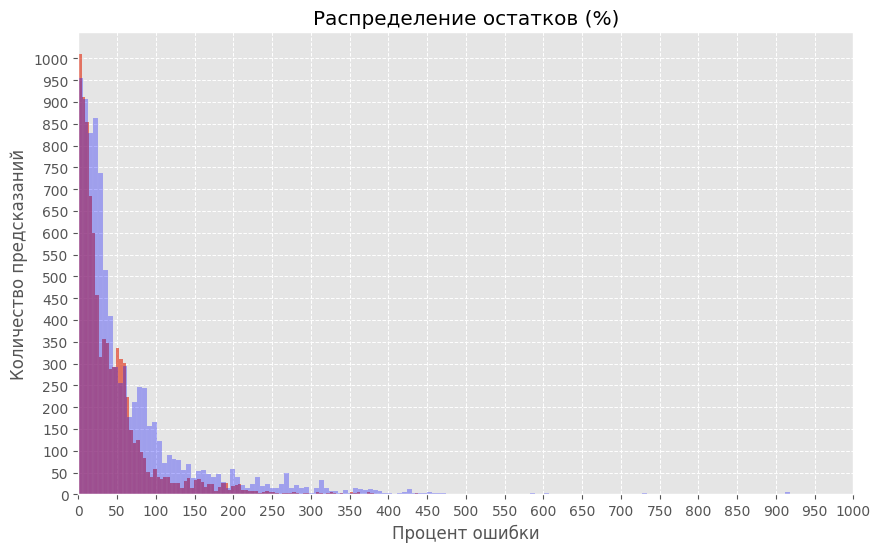

In [15]:
# Построение гистограммы с помощью Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(compare, x='base_percent_error')
sns.histplot(compare, x='linear_percent_error', color='blue', alpha=0.3)

# Ограничиваем значения по оси X до 1000
plt.xlim(0,1000)

# Задаем шаг для меток оси X (например, шаг 100)
step = 50
plt.xticks(np.arange(0, 1001, step))
plt.yticks(np.arange(0, 1001, step))

# Включаем сетку и задаем тот же шаг
plt.grid(True, axis='x', which='both', linestyle='--', linewidth=0.7)
plt.grid(True, axis='y', which='both', linestyle='--', linewidth=0.7)


# Добавим подписи и заголовок (если нужно)
plt.xlabel('Процент ошибки')
plt.ylabel('Количество предсказаний')
plt.title('Распределение остатков (%)')

plt.show()

Пока что нет, как минимум явного, преимущества перед базовой моделью. 

Регрессия дает больше предсказаний с ошибкой до 50%, но и больше с очень большой ошибкой (более 200%)

## Улучшение модели (регуляризация)

Попробуем добавить разные методы регуляризации

### lasso

In [16]:
search_lasso = GridSearchCV(estimator=Lasso(),
                           param_grid={'alpha': np.arange(0.01, 10, 0.05)})
search_lasso.fit(X_val_scaled, y_val)
best_lasso = search_lasso.best_estimator_
print("Best alpha:", best_lasso.alpha)

Best alpha: 0.26


In [17]:
with mlflow.start_run(run_name="Lasso"):
    mlflow.log_param("model_type", "Lasso")
        
    start_time = datetime.now()
    lasso_reg = Lasso(alpha=best_lasso.alpha)
    lasso_reg.fit(X, y)
    y_lasso_predict = lasso_reg.predict(X_test[cols])
    compare['y_lasso_predict'] = y_lasso_predict
    end_time = datetime.now()
        
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
        
    lasso_metrics = get_and_print_metrics(y_lasso_predict, y_test)     
    
    for key, value in lasso_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.sklearn.log_model(reg, "lasso_regression_model")



RMSE: 24.699942425977806
MAPE: 64.06%
SMAPE: 48.34%
R2: 0.66
Процент значений с ошибкой не более 20%: 32.83%
WAPE: 36.57%


2024/10/03 22:29:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### ridge

In [18]:
search_ridge = GridSearchCV(estimator=Ridge(),
                           param_grid={'alpha': np.arange(0.01, 10, 0.05)})
search_ridge.fit(X_val_scaled, y_val)
best_ridge = search_ridge.best_estimator_
print("Best alpha:", best_ridge.alpha)

Best alpha: 9.96


In [19]:
with mlflow.start_run(run_name="Ridge"):
    mlflow.log_param("model_type", "Ridge")
        
    start_time = datetime.now()
    ridge_reg = Ridge(alpha=best_ridge.alpha)
    ridge_reg.fit(X, y)
    y_ridge_predict = ridge_reg.predict(X_test[cols])
    compare['y_ridge_predict'] = y_ridge_predict
    end_time = datetime.now()
        
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
        
    ridge_metrics = get_and_print_metrics(y_ridge_predict, y_test)  
    
    for key, value in ridge_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.sklearn.log_model(reg, "ridge_regression_model")



RMSE: 24.629051869002442
MAPE: 67.23%
SMAPE: 50.49%
R2: 0.67
Процент значений с ошибкой не более 20%: 32.03%
WAPE: 37.00%


2024/10/03 22:31:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### ElasticNet

In [20]:
# Определение пространства поиска гиперпараметров
param_grid = {
    'alpha': np.logspace(-3, 3, 10),
    'l1_ratio': np.linspace(0.01, 1, 100)
}

# Инициализация RandomizedSearchCV
random_search_elnet = RandomizedSearchCV(
    estimator=ElasticNet(),
    param_distributions=param_grid,
    cv=5,  # Количество кросс-валидаций
    n_iter=50,  # Количество итераций для случайного подбора
    random_state=42,  # Для воспроизводимости результатов
)

# Подбор гиперпараметров
random_search_elnet.fit(X_val_scaled,y_val)

# Получение лучшей модели
best_random_elnet = random_search_elnet.best_params_

l1_ratio_best = best_random_elnet['l1_ratio']
alpha_best = best_random_elnet['alpha']

print(f"Best l1_ratio: {l1_ratio_best}")
print(f"Best alpha: {alpha_best}")

/home/mikhail/projects/laser_cutting/laser_cutting/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.251e+04, tolerance: 1.249e+03
  model = cd_fast.enet_coordinate_descent(
/home/mikhail/projects/laser_cutting/laser_cutting/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.951e+04, tolerance: 1.233e+03
  model = cd_fast.enet_coordinate_descent(
/home/mikhail/projects/laser_cutting/laser_cutting/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Best l1_ratio: 0.7100000000000001
Best alpha: 0.1


In [21]:
with mlflow.start_run(run_name="ElasticNet"):
    mlflow.log_param("model_type", "ElasticNet")
        
    start_time = datetime.now()
    elasticnet_reg = ElasticNet(alpha=0.001, l1_ratio=0.97)
    elasticnet_reg.fit(X, y)
    y_elasticnet_predict = elasticnet_reg.predict(X_test[cols])
    compare['y_elasticnet_predict'] = y_elasticnet_predict
    end_time = datetime.now()
        
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
        
    elasticnet_metrics = get_and_print_metrics(y_elasticnet_predict, y_test)  
    
    for key, value in elasticnet_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.sklearn.log_model(reg, "ElasticNet_regression_model")




RMSE: 24.60896673244604
MAPE: 68.04%
SMAPE: 50.94%
R2: 0.67
Процент значений с ошибкой не более 20%: 31.86%
WAPE: 37.09%


2024/10/03 22:32:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Сравнение результатов

In [22]:
lasso_metrics['model_name'] = 'lasso'
elasticnet_metrics['model_name'] = 'elasticNet'
ridge_metrics['model_name'] = 'ridge'

In [23]:
metrics_dicts.extend(
    [lasso_metrics,
    elasticnet_metrics,
    ridge_metrics]
)

In [24]:
# Создаем DataFrame из списка словарей
compare_metrics = pd.DataFrame(metrics_dicts)

# Переименуем столбец 'model_name' в индекс DataFrame
compare_metrics.set_index('model_name', inplace=True)

compare_metrics

,rmse,mape,smape,R2,percentage_within_20,wape
model_name,,,,,,
base,35.392,0.480,39.181,0.310,43.131,41.873
linear,24.624,0.682,51.049,0.666,31.807,37.135
lasso,24.700,0.641,48.343,0.664,32.833,36.573
elasticNet,24.609,0.680,50.942,0.666,31.863,37.088
ridge,24.629,0.672,50.492,0.666,32.032,37.005


Базовая модель дает 43.131% предсказаний, с ошибкой меньше 20%. Что лучше любой регрессии. 
Проигрывает регрессии только по rmse

lasso - лучшая из регрессий, но не имеет явного преимущества перед baseline

Следующий шаг - попробовать полиномиальную регрессию

## Улучшение модели (полином)

Подберем оптимальную степень полинома, ограничемся выбором из 1,2,3

In [25]:
from sklearn.pipeline import Pipeline

# pipeline:сначала применяюются полиномиальные признаки и затем линейная регрессия
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()),
    ('linear_regression', LinearRegression())
])

# Определение сетки гиперпараметров
param_grid = {
    'poly_features__degree': range(1, 4) 
}

# Настройка GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Подвыборка данных для ускорения процесса (если нужно)
small_X_train = X_val_scaled[cols].sample(n=2000, random_state=42)
small_y_train = y_val.sample(n=2000, random_state=42)

# Обучение модели на подвыборке данных
grid_search.fit(small_X_train, small_y_train)

# Лучшая степень полинома
best_degree = grid_search.best_params_['poly_features__degree']
print(f'Оптимальная степень полинома: {best_degree}')


Оптимальная степень полинома: 2


Используем полином 2 степени

In [26]:
poly_feat = PolynomialFeatures(degree=best_degree)
X_poly = poly_feat.fit_transform(pd.DataFrame(X_train[cols]))

with mlflow.start_run(run_name="Poly"):
    mlflow.log_param("model_type", "Poly")
        
    start_time = datetime.now()
    reg_poly = LinearRegression()
    reg_poly.fit(X_poly, y_train)    

    y_poly_predict = reg_poly.predict(poly_feat.transform(X_test[cols]))
    compare['y_poly_predict'] = y_poly_predict
    end_time = datetime.now()
        
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
        
    y_poly_metrics = get_and_print_metrics(y_poly_predict, y_test)
    
    for key, value in y_poly_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.sklearn.log_model(reg, "Polynomial_regression_model")






RMSE: 17.66141560808276
MAPE: 25.75%
SMAPE: 21.61%
R2: 0.83
Процент значений с ошибкой не более 20%: 65.23%
WAPE: 19.23%


2024/10/03 22:35:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [27]:
new_row = pd.Series(y_poly_metrics.values(), 
                    index=['rmse', 'mape', 'smape', 'R^2', 'percentage_within_20', 'wape'])

# Добавляем новую строку в DataFrame
compare_metrics.loc['poly'] = new_row

In [28]:
compare_metrics 

,rmse,mape,smape,R2,percentage_within_20,wape
model_name,,,,,,
base,35.392,0.480,39.181,0.310,43.131,41.873
linear,24.624,0.682,51.049,0.666,31.807,37.135
lasso,24.700,0.641,48.343,0.664,32.833,36.573
elasticNet,24.609,0.680,50.942,0.666,31.863,37.088
ridge,24.629,0.672,50.492,0.666,32.032,37.005
poly,17.661,0.258,21.615,NaN,65.227,19.229


# Визуализация результатов

Также, как выше, посмотрим распределение остатков base с poly

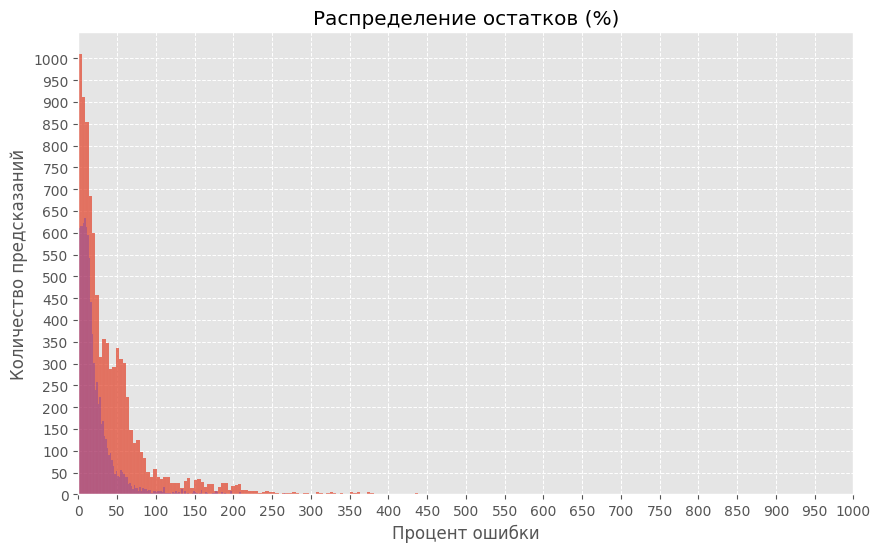

In [29]:
compare['poly_percent_error'] = compare.apply(lambda x: get_percent_error(x['y_poly_predict'], x['Time']), axis=1)

# Построение гистограммы с помощью Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(compare, x='base_percent_error')
sns.histplot(compare, x='poly_percent_error', color='blue', alpha=0.2)

# Ограничиваем значения по оси X до 1000
plt.xlim(0,1000)

# Задаем шаг для меток оси X (например, шаг 100)
step = 50
plt.xticks(np.arange(0, 1001, step))
plt.yticks(np.arange(0, 1001, step))

# Включаем сетку и задаем тот же шаг
plt.grid(True, axis='x', which='both', linestyle='--', linewidth=0.7)
plt.grid(True, axis='y', which='both', linestyle='--', linewidth=0.7)


# Добавим подписи и заголовок (если нужно)
plt.xlabel('Процент ошибки')
plt.ylabel('Количество предсказаний')
plt.title('Распределение остатков (%)')

plt.show()

Почти все предсказания poly скучены до ошибки в 50%

Посмотрим на линию предсказания для 2х главных признаков (корреляция > 0.5) 
- длина реза
- количество врезок

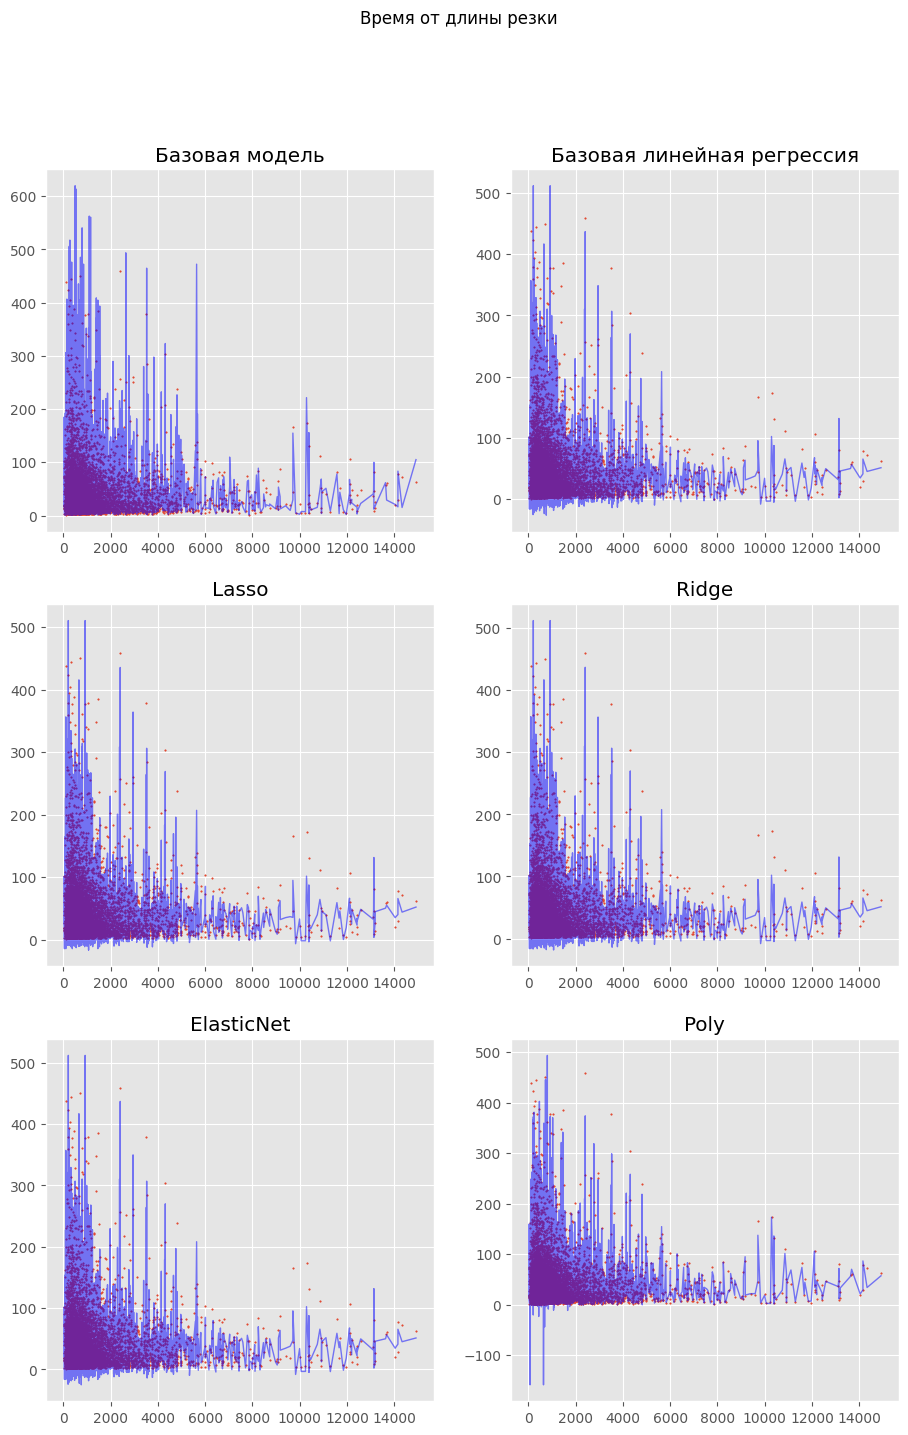

In [32]:
X = X_test['Cut_length'].sort_values()


fig, ax = plt.subplots(3, 2, figsize=(11,16))
fig.suptitle('Время от длины резки')


ax[0,0].scatter(X, y_test, s=1)
ax[0,1].scatter(X, y_test, s=1)
ax[1,0].scatter(X, y_test, s=1)
ax[1,1].scatter(X, y_test, s=1)
ax[2,0].scatter(X, y_test, s=1)
ax[2,1].scatter(X, y_test, s=1)


ax[0,0].set_title('Базовая модель')
ax[0,1].set_title('Базовая линейная регрессия')
ax[1,0].set_title('Lasso')
ax[1,1].set_title('Ridge')
ax[2,0].set_title('ElasticNet')
ax[2,1].set_title('Poly')


ax[0,0].plot(X, compare['base_y_pred'], lw=1, color = 'blue', alpha = 0.5)
ax[0,1].plot(X, compare['y_linear_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[1,0].plot(X, compare['y_lasso_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[1,1].plot(X, compare['y_ridge_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[2,0].plot(X, compare['y_elasticnet_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[2,1].plot(X, compare['y_poly_predict'], lw=1, color = 'blue', alpha = 0.5);

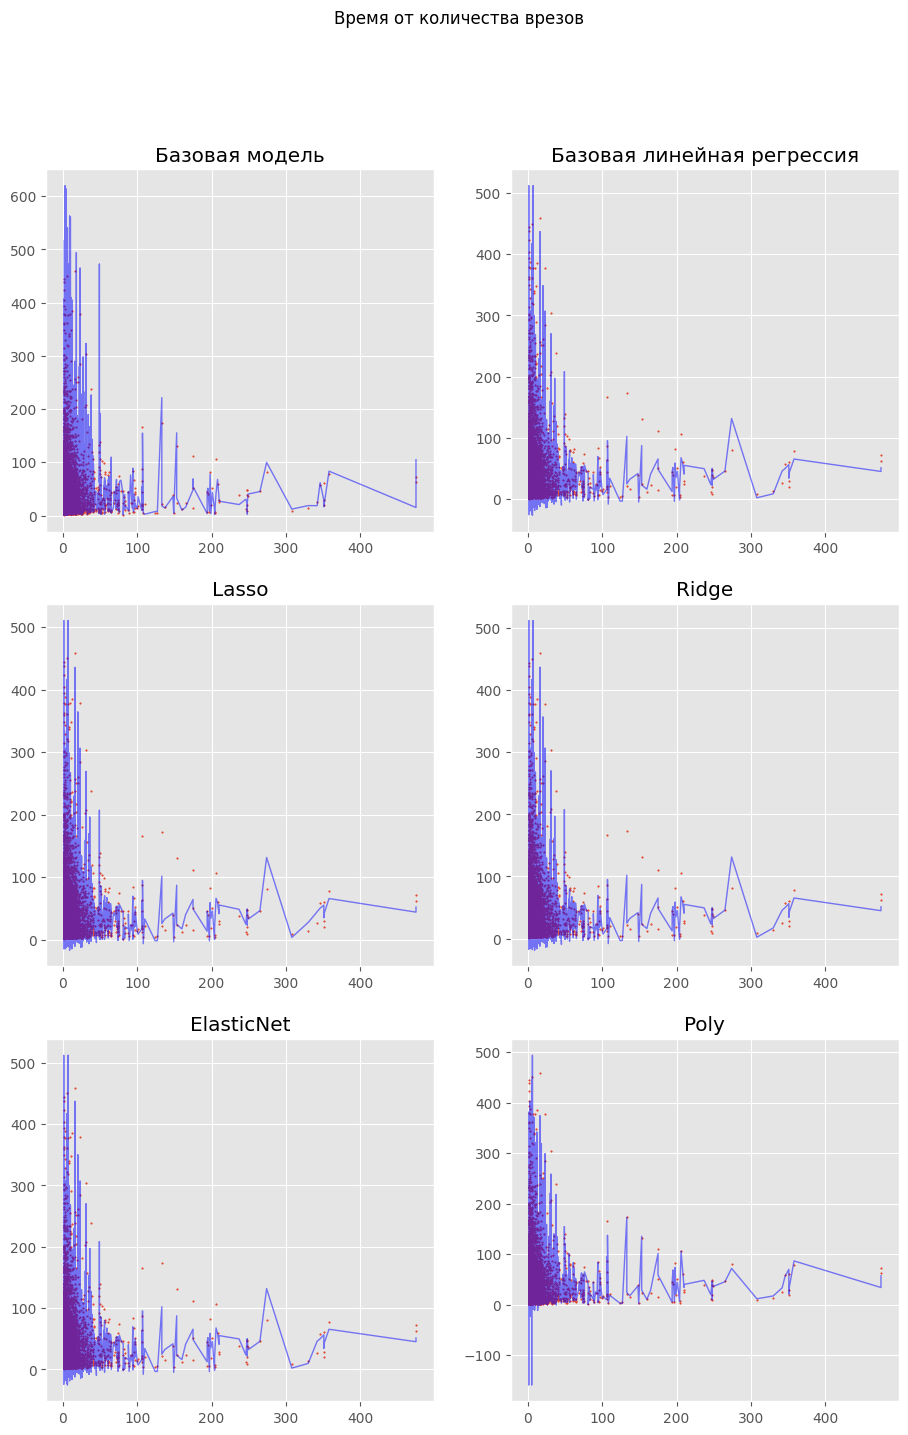

In [33]:
X = X_test['Cut_quantity'].sort_values()


fig, ax = plt.subplots(3, 2, figsize=(11,16))
fig.suptitle('Время от количества врезов')


ax[0,0].scatter(X, y_test, s=1)
ax[0,1].scatter(X, y_test, s=1)
ax[1,0].scatter(X, y_test, s=1)
ax[1,1].scatter(X, y_test, s=1)
ax[2,0].scatter(X, y_test, s=1)
ax[2,1].scatter(X, y_test, s=1)


ax[0,0].set_title('Базовая модель')
ax[0,1].set_title('Базовая линейная регрессия')
ax[1,0].set_title('Lasso')
ax[1,1].set_title('Ridge')
ax[2,0].set_title('ElasticNet')
ax[2,1].set_title('Poly')


ax[0,0].plot(X, compare['base_y_pred'], lw=1, color = 'blue', alpha = 0.5)
ax[0,1].plot(X, compare['y_linear_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[1,0].plot(X, compare['y_lasso_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[1,1].plot(X, compare['y_ridge_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[2,0].plot(X, compare['y_elasticnet_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[2,1].plot(X, compare['y_poly_predict'], lw=1, color = 'blue', alpha = 0.5);

Полиноминальная регрессия точнее приближена к точкам

Однако, есть предсказания меньше 0

In [35]:
len(compare[compare['y_poly_predict']<0])

39

In [36]:
compare[compare['y_poly_predict']<0][['Time', 'y_poly_predict']][:10]

,Time,y_poly_predict
121392,162.000,-158.749
24178,3.000,-1.152
303797,1.000,-1.649
176035,2.000,-0.361
102603,4.000,-20.466
425726,4.000,-0.632
294251,2.000,-1.474
23902,2.000,-0.122
146945,2.000,-0.205
146953,2.000,-0.028


Таких предсказаний всего 39, и судя по значениям, для многих, можно использовать просто модуль.

Считаем, что полиноминальная модель справилась хорошо

# Итог

С линейной регрессией не получилось добиться значительного улучшения относительно базовой модели.

Незначительное улучшение дает lasso регуляризация. 

Значительное улучшение в качестве (приемлимое для ухода от базовой модели) получено с использованием полиномиальных признаков 2 степени. 

Для дальнейшего улучшения модели можно попробовать изменить предобработку данных.

Следующий шаг - использование mlflow для автоматизации процесса предобработки (отдельный блокнот)